In [62]:
import esm
import torch
from transformers import AutoTokenizer, EsmForMaskedLM
from time import time

In [63]:
from typing import List, Tuple, Optional, Dict, NamedTuple, Union, Callable
import itertools
import os
import string
from pathlib import Path

import numpy as np
import torch
from Bio import SeqIO, Phylo
import pandas as pd
from scipy.spatial.distance import squareform, pdist, cdist
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

import esm

torch.set_grad_enabled(False)

In [64]:
deletekeys = dict.fromkeys(string.ascii_lowercase)
deletekeys["."] = None
deletekeys["*"] = None
translation = str.maketrans(deletekeys)

def read_sequence(filename: str) -> Tuple[str, str]:
    """ Reads the first (reference) sequences from a fasta or MSA file."""
    record = next(SeqIO.parse(filename, "fasta"))
    return record.description, str(record.seq)

def remove_insertions(sequence: str) -> str:
    """ Removes any insertions into the sequence. Needed to load aligned sequences in an MSA. """
    return sequence.translate(translation)

def read_msa(filename: str) -> List[Tuple[str, str]]:
    """ Reads the sequences from an MSA file, automatically removes insertions."""
    return [(record.description, remove_insertions(str(record.seq))) for record in SeqIO.parse(filename, "fasta")]

In [65]:
MSA_filename = "PF00004"

In [66]:
### In case sequences don't have names

# x = SeqIO.parse(f"{MSA_filename}.fasta", "fasta")

# x = [SeqRecord(Seq(remove_insertions(str(record.seq))), id = f"seq{i}", description=f"seq{i}") for i,record in enumerate(x)]

# with open("1a3a_1_A_named.a3m", "w") as output_handle:
#     SeqIO.write(x, output_handle, "fasta")

In [67]:
x = [(record.description, remove_insertions(str(record.seq))) for record in SeqIO.parse(f"{MSA_filename}.fasta", "fasta")]

In [68]:
def greedy_select(msa: List[Tuple[str, str]], num_seqs: int, mode: str = "max") -> List[Tuple[str, str]]:
    assert mode in ("max", "min")
    if len(msa) <= num_seqs:
        return msa
    
    array = np.array([list(seq) for _, seq in msa], dtype=np.bytes_).view(np.uint8)

    optfunc = np.argmax if mode == "max" else np.argmin
    all_indices = np.arange(len(msa))
    indices = [0]
    pairwise_distances = np.zeros((0, len(msa)))
    for _ in range(num_seqs - 1):
        dist = cdist(array[indices[-1:]], array, "hamming")
        pairwise_distances = np.concatenate([pairwise_distances, dist])
        shifted_distance = np.delete(pairwise_distances, indices, axis=1).mean(0)
        shifted_index = optfunc(shifted_distance)
        index = np.delete(all_indices, indices)[shifted_index]
        indices.append(index)
    indices = sorted(indices)
    return [msa[idx] for idx in indices]

In [69]:
num_seqs = 100
sampled_MSA_tuples = greedy_select(x, num_seqs=num_seqs)

In [70]:
sampled_MSA_SeqRecords = [SeqRecord(Seq(record[1]), id = record[0], name= record[0], description= record[0]) for record in sampled_MSA_tuples]

In [71]:
with open(f"{MSA_filename}_sampled_{num_seqs}.fasta", "w") as output_handle:
    SeqIO.write(sampled_MSA_SeqRecords, output_handle, "fasta")

In [72]:
tree = Phylo.read(f"{MSA_filename}_sampled_{num_seqs}.tree","newick")
tree.root_at_midpoint()

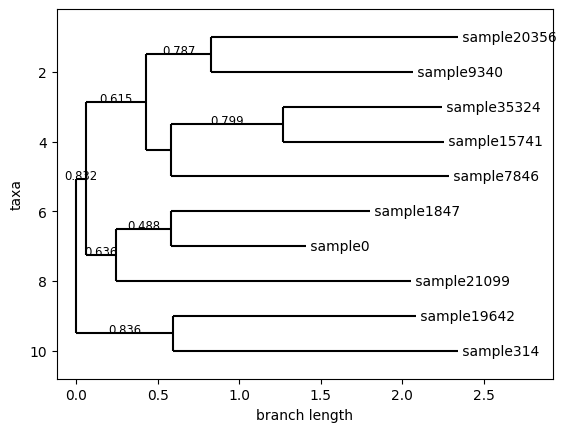

In [73]:
Phylo.draw(tree)

In [13]:
torch.cuda.empty_cache()

device = "cuda" if torch.cuda.is_available() else "cpu"
model, alphabet = esm.pretrained.esm_msa1b_t12_100M_UR50S()
model = model.to(device)
# batch_converter = alphabet.get_batch_converter()
# model.eval() 

In [14]:
alphabet.to_dict()

{'<cls>': 0,
 '<pad>': 1,
 '<eos>': 2,
 '<unk>': 3,
 'L': 4,
 'A': 5,
 'G': 6,
 'V': 7,
 'S': 8,
 'E': 9,
 'R': 10,
 'T': 11,
 'I': 12,
 'D': 13,
 'P': 14,
 'K': 15,
 'Q': 16,
 'N': 17,
 'F': 18,
 'Y': 19,
 'M': 20,
 'H': 21,
 'W': 22,
 'C': 23,
 'X': 24,
 'B': 25,
 'U': 26,
 'Z': 27,
 'O': 28,
 '.': 29,
 '-': 30,
 '<null_1>': 31,
 '<mask>': 32}

In [14]:
# _,_,batch_tokens = batch_converter([sampled_MSA_tuples])
# batch_tokens = batch_tokens.to(device)


In [15]:
# base_state_dict = {}
# for name, param in model.state_dict().items():
#     if not (name.startswith("lm_head") or name.startswith("contact_head")):
#         base_state_dict[name] = param

# lm_head_state_dict = {}
# for name, param in model.state_dict().items():
#     if name.startswith("lm_head") or name == "embed_tokens.weight":
#         lm_head_state_dict[name] = param


In [16]:
# from msa_light import MSATransformer
# from msa_lm_head import MSATransformer_lm_head
# from tokenization import Vocab

# msa_light = MSATransformer(vocab = Vocab.from_esm_alphabet(alphabet))
# msa_light = msa_light.to(device)

# msa_lm_head = MSATransformer_lm_head(vocab = Vocab.from_esm_alphabet(alphabet))
# msa_lm_head = msa_lm_head.to(device)

In [17]:
# msa_light.load_state_dict(base_state_dict, strict=True)
# msa_lm_head.load_state_dict(lm_head_state_dict, strict=True)

In [18]:
# embeds = msa_light(batch_tokens, repr_layers = [12])["representations"][12]
# logits = msa_lm_head(embeds[0,0,:,:])["logits"]

In [16]:
%load_ext cython

In [74]:
%%cython -a

# cython: language_level=3, boundscheck=False, wraparound=False, initializedcheck=False, cdivision=True
# distutils: extra_compile_args=-fopenmp
# distutils: extra_link_args=-fopenmp

import numpy as np
cimport cython
from libc.stdlib cimport RAND_MAX
from libc.stdlib cimport rand, srand
from posix.stdlib cimport drand48
from generation_sequence cimport exp
from libc.time cimport time
from cython.parallel import prange

cdef class Creation_MSA_Generation:

    cdef double[:,::1] Field
    cdef double[:,:,:,::1] Coupling
    cdef int Number_state_spin
    cdef int Number_of_Node
    cdef int seq_counter
    
    def __init__(self, double[:,::1] Field, double[:,:,:,::1] Coupling ):

        self.Number_of_Node = np.intc(Field.shape[0])
        self.Number_state_spin = np.intc(Field.shape[1])
        self.Field = Field
        self.Coupling = Coupling
        self.seq_counter = 0
        srand(<unsigned int>time(NULL))
        
    def msa_no_phylo(self, int n_sequences, int n_flip_equi):
        cdef:
            int index_msa
            char[:,::1] msa = np.random.randint(0,high=self.Number_state_spin, 
                                size = (n_sequences,self.Number_of_Node)
                                ,dtype = np.int8)
        for index_msa in prange(msa.shape[0],nogil=True,schedule='dynamic'):
            self.mcmc(n_flip_equi, msa[index_msa])
        return np.asarray(msa)
                
    def msa_phylo(self, int n_generations, int n_mutations_generation, int flip_before_start):
        cdef:
            char[::1] l_spin = np.random.randint(0,
                                                 high=self.Number_state_spin
                                                 ,size = ( self.Number_of_Node)
                                                ,dtype = np.int8)
            char[:,::1] msa = np.zeros((int(2**n_generations),self.Number_of_Node)
                                ,dtype = np.int8)
            int generation,index_sequence
        self.seq_counter = 0
        self.mcmc(flip_before_start, l_spin)     
        msa[0] = l_spin
        for generation in range(1,n_generations+1):
            msa[int(2**(generation-1)):int(2**generation),:] = msa[0:int(2**(generation-1)),:]
            for index_sequence in range(int(2**generation)):
                self.mcmc(n_mutations_generation, msa[index_sequence])
        return np.asarray(msa)
    
    def msa_tree_phylo(self, clade_root, int flip_before_start, double neff = 1.0):
        cdef :
            char[::1] first_sequence = np.random.randint(0,high=self.Number_state_spin
                                                         ,size = ( self.Number_of_Node)
                                                         ,dtype = np.int8)  
            #char[:,::1] msa = np.random.randint(0,high=self.Number_state_spin, 
            #                                    size = (len(clade_root.get_terminals()),self.Number_of_Node)
            #                                    ,dtype = np.int8)
            char[:,::1] msa = np.zeros((len(clade_root.get_terminals()),self.Number_of_Node), dtype=np.int8)
        self.mcmc(flip_before_start, first_sequence)
        return np.asarray(self.msa_tree_phylo_recur(clade_root, first_sequence, msa, neff))
    
    cdef char[:,::1] msa_tree_phylo_recur(self, clade_root, char[::1] previous_sequence, char[:,::1] msa, double neff):
        cdef:
            char[::1] new_sequence = np.zeros((previous_sequence.shape[0]),dtype=np.int8)
            int n_mutations
        b = clade_root.clades
        if len(b)>0:
            for clade in b:
                #Mutation on previous_sequences
                new_sequence[:] = previous_sequence
                n_mutations = int(clade.branch_length*new_sequence.shape[0]*neff)
                self.mcmc(n_mutations, new_sequence)
                self.msa_tree_phylo_recur(clade, new_sequence, msa, neff)
        else:
            # n_mutations = int(clade_root.branch_length*previous_sequence.shape[0]*neff)
            # self.mcmc(n_mutations, previous_sequence)
            msa[self.seq_counter,:] = previous_sequence
            self.seq_counter += 1
        return msa
    
    def hamiltonian(self,char[::1] L_Spin):
        cdef:
            int node_i,index_neighboor
            double hamiltonian = 0.0
        for node_i in range(self.Number_of_Node-1):
            hamiltonian -= self.Field[node_i,L_Spin[node_i]]
            for index_neighboor in range(node_i+1,self.Number_of_Node):
                hamiltonian -= self.Coupling[node_i,index_neighboor,L_Spin[node_i],L_Spin[index_neighboor]]
        return hamiltonian 
  
    cdef inline void mcmc(self, int Number_of_Mutation, char[::1] L_Spin) nogil:  
        cdef:
            int selected_node, new_state, c_mutation = 0
            double Prob, de
        while c_mutation<Number_of_Mutation:   
            selected_node = randint(0,self.Number_of_Node)
            new_state = randint(0,self.Number_state_spin-1)
            if new_state >= L_Spin[selected_node]:
                new_state += 1 
            de = (
                self.Pseudo_Hamiltonian(selected_node, new_state, L_Spin) -
                self.Pseudo_Hamiltonian(selected_node, L_Spin[selected_node], L_Spin)
                 )
            if de>=0 or (rand() / (RAND_MAX + 1.0)) < exp(de):
                L_Spin[selected_node]= new_state
                c_mutation += 1

    cdef inline double Pseudo_Hamiltonian(self, int node, int state_node, char[::1] L_Spin) nogil:
        cdef:
            int i
            double hamiltonian = self.Field[node,state_node] - self.Coupling[node,node,state_node,L_Spin[node]]
        for i in range(L_Spin.shape[0]):
            hamiltonian += self.Coupling[node,i,state_node,L_Spin[i]]
        return hamiltonian 

cdef inline int randint(int lower, int upper) nogil:

    return rand() % (upper - lower ) + lower 


In [171]:
fields_bmDCA = np.load("PF00004_h.npy")
couplings_bmDCA = np.load("PF00004_J.npy")

MSA_gen_obj_Potts = Creation_MSA_Generation(Coupling = couplings_bmDCA, Field =  fields_bmDCA)

In [172]:
new_msa = MSA_gen_obj_Potts.msa_tree_phylo(tree.clade, 0)

In [175]:
new_msa_no_phylo = MSA_gen_obj_Potts.msa_no_phylo(100,100000)

In [176]:
# %%cython -a

# cython: language_level=3, boundscheck=False, wraparound=False, initializedcheck=False, cdivision=True
# distutils: extra_compile_args=-fopenmp
# distutils: extra_link_args=-fopenmp

import numpy as np
cimport cython
from libc.stdlib cimport RAND_MAX
from libc.math cimport exp
# from libc.time cimport time
# from cython.parallel import prange

class Creation_MSA_Generation_MSA1b:

    cdef int n_rows
    cdef int n_cols
    
    def __init__(self, MSA, start_seq_index = 0, seed = 42):

        if start_seq_index != 0:
            start_seq = MSA[start_seq_index].copy()
            del MSA[start_seq_index]
            MSA = [start_seq] + MSA

        torch.cuda.empty_cache()

        self.original_MSA = MSA
        self.phylogeny_MSA = []
        self.device = "cuda" if torch.cuda.is_available() else "cpu"

        self.bmdca_mapping_dict = dict(zip(range(21), list("-ACDEFGHIKLMNPQRSTVWY")))

        self.n_rows = len(self.original_MSA)
        self.n_cols = len(self.original_MSA[0][1])
        
        self.model, self.alphabet = esm.pretrained.esm_msa1b_t12_100M_UR50S()
        self.model = self.model.to(self.device)

        self.model_alphabet_mapping = self.alphabet.to_dict()
        self.model_alphabet_mapping_inv = dict(zip(range(len(self.alphabet.all_toks)), self.alphabet.all_toks))
        self.batch_converter = self.alphabet.get_batch_converter()
        self.model.eval() 

        _,_,self.constant_batch_tokens = self.batch_converter([self.original_MSA[1:]])
        self.constant_batch_tokens = self.constant_batch_tokens.to(next(self.model.parameters()).device)
        
        _,_,self.start_seq_batch_tokens = self.batch_converter([self.original_MSA[:1]])
        self.start_seq_batch_tokens = self.start_seq_batch_tokens.to(next(self.model.parameters()).device)
    
        self.random_seed = seed

    def prob_calculator(self, batch_tokens, selected_pos):

        softmax = torch.nn.Softmax(dim = -1)
        probs = softmax(self.model(batch_tokens, need_head_weights = False, return_contacts = False)["logits"]).cpu().numpy()
        
        log_prob_row = 0
        
        for i in range(1,self.n_cols +1):
            char_index = batch_tokens[0,0,i]
            log_prob_row += np.log(probs[0,0,i,char_index])
                                           
        log_prob_col = 0
        
        for i in range(self.n_rows):
            char_index = batch_tokens[0,i,selected_pos]
            log_prob_col += np.log(probs[0,i,selected_pos,char_index])

        mut_char_index = batch_tokens[0,0,selected_pos]
        log_total_prob = log_prob_row + log_prob_col - np.log(probs[0,0,selected_pos,mut_char_index])


        return log_total_prob
        
    def msa_no_phylo(self, n_sequences, n_flip_equi):

        output_MSA = []
        
        for index in range(self.n_rows):

            MSA = self.original_MSA.copy()
            
            start_seq = MSA[index]
            del MSA[index]
            MSA = [start_seq] + MSA

            _,_,self.constant_batch_tokens = self.batch_converter([self.original_MSA[1:]])
            self.constant_batch_tokens = self.constant_batch_tokens.to(self.device)
        
            _,_,self.start_seq_batch_tokens = self.batch_converter([self.original_MSA[:1]])
            self.start_seq_batch_tokens = self.start_seq_batch_tokens.to(self.device)
            
            new_batch_tokens = self.mcmc(n_flip_equi, self.start_seq_batch_tokens)

            final_seq = ""
            for i in range(1,self.n_cols+1):
    
                char_index = int(new_batch_tokens[0,0,i].cpu().numpy())
                char = self.model_alphabet_mapping_inv[char_index]
                final_seq += char
                
            seq_index = len(output_MSA)
            output_MSA.append((f"seq{seq_index}",final_seq))      
            
        
        ### return to original state
        
        _,_,self.constant_batch_tokens = self.batch_converter([self.original_MSA[1:]])
        self.constant_batch_tokens = self.constant_batch_tokens.to(self.device)
        
        _,_,self.start_seq_batch_tokens = self.batch_converter([self.original_MSA[:1]])
        self.start_seq_batch_tokens = self.start_seq_batch_tokens.to(self.device)

        ###

        return output_MSA
            
                
    def msa_phylo(self, n_generations, n_mutations_generation, flip_before_start):
        l_spin = np.random.randint(0,high=self.Number_state_spin
                                    ,size = ( self.Number_of_Node)
                                    ,dtype = np.int8)
    
        msa = np.zeros((int(2**n_generations),self.Number_of_Node)
                                ,dtype = np.int8)

        self.mcmc(flip_before_start, l_spin) 

        msa[0] = l_spin
        for generation in range(1,n_generations+1):
            msa[int(2**(generation-1)):int(2**generation),:] = msa[0:int(2**(generation-1)),:]
            for index_sequence in range(int(2**generation)):
                self.mcmc(n_mutations_generation, msa[index_sequence])
        return np.asarray(msa)
    
    def msa_tree_phylo(self, clade_root, flip_before_start, neff = 1.0):
                
        first_sequence_batch_tokens = self.mcmc(flip_before_start, self.start_seq_batch_tokens)
        self.msa_tree_phylo_recur(clade_root, first_sequence_batch_tokens, neff)
    
    def msa_tree_phylo_recur(self, clade_root, previous_sequence_batch_tokens, neff):
        
        b = clade_root.clades
        
        if len(b)>0:
            for clade in b:
                #Mutation on previous_sequences
                print("entering new clade")
                n_mutations = int(clade.branch_length*self.n_cols*neff)
                new_sequence_batch_tokens = self.mcmc(n_mutations, previous_sequence_batch_tokens)
                self.msa_tree_phylo_recur(clade, new_sequence_batch_tokens, neff)
        else:
            # n_mutations = int(clade_root.branch_length*self.n_cols*neff)
            # new_sequence_batch_tokens = self.mcmc(n_mutations, previous_sequence_batch_tokens)
            final_seq = ""
            for i in range(1,self.n_cols+1):

                char_index = int(previous_sequence_batch_tokens[0,0,i].cpu().numpy())
                char = self.model_alphabet_mapping_inv[char_index]
                final_seq += char
                
            print(final_seq)
            
            seq_index = len(self.phylogeny_MSA)
            self.phylogeny_MSA.append((f"seq{seq_index}",final_seq))
    
    def mcmc(self, Number_of_Mutation, previous_sequence_batch_tokens):  
    
        c_mutation = 0
        print(f"Number of mutations: {Number_of_Mutation}")
        
        while c_mutation<Number_of_Mutation:

            stacked_batch_tokens = torch.cat((previous_sequence_batch_tokens, self.constant_batch_tokens), dim = 1)
            
            selected_pos = np.random.randint(1, high = self.n_cols + 1)

            orig_log_prob = self.prob_calculator(stacked_batch_tokens, selected_pos)
            
            proposed_mutation = np.random.randint(0, high = len(self.bmdca_mapping_dict))
            proposed_mutation = self.bmdca_mapping_dict[proposed_mutation]
            proposed_mutation = self.model_alphabet_mapping[proposed_mutation]

            modified_sequence_batch_tokens = previous_sequence_batch_tokens
            modified_sequence_batch_tokens[0,0,selected_pos] = proposed_mutation
            modified_stacked_batch_tokens = torch.cat((modified_sequence_batch_tokens, self.constant_batch_tokens), dim = 1)

            new_log_prob = self.prob_calculator(modified_stacked_batch_tokens, selected_pos)
            
            de = new_log_prob - orig_log_prob
                
            if de >= 0 or np.random.rand() < np.exp(de):
                previous_sequence_batch_tokens = modified_sequence_batch_tokens
                c_mutation += 1

        return previous_sequence_batch_tokens
            
MSA_gen_obj = Creation_MSA_Generation_MSA1b(MSA = sampled_MSA_tuples)

In [58]:
%%cython -a

import numpy as np
cimport cython
from libc.stdlib cimport RAND_MAX, rand, srand
from libc.math cimport exp
import torch
import esm
from msa_light import MSATransformer
from msa_lm_head import MSATransformer_lm_head
from tokenization import Vocab
# from libc.time cimport time
# from cython.parallel import prange

@cython.cdivision(True)
cdef inline int randint(int lower, int upper) nogil:

    return rand() % (upper - lower) + lower

class Creation_MSA_Generation_MSA1b_Cython:

    # cdef int n_rows
    # cdef int n_cols
    
    def __init__(self, MSA, start_seq_index = 0, seed = 42):

        if start_seq_index != 0:
            start_seq = MSA[start_seq_index].copy()
            del MSA[start_seq_index]
            MSA = [start_seq] + MSA

        torch.cuda.empty_cache()

        self.original_MSA = MSA
        self.phylogeny_MSA = []
        self.device = "cuda" if torch.cuda.is_available() else "cpu"

        self.n_rows = len(self.original_MSA)
        self.n_cols = len(self.original_MSA[0][1])
        
        self.model, self.alphabet = esm.pretrained.esm_msa1b_t12_100M_UR50S()
        self.model = self.model.to(self.device)

        self.model_alphabet_mapping = self.alphabet.to_dict()
        self.model_alphabet_mapping_inv = dict(zip(range(len(self.alphabet.all_toks)), self.alphabet.all_toks))
        self.batch_converter = self.alphabet.get_batch_converter()
        self.model.eval() 

        base_state_dict = {}
        for name, param in self.model.state_dict().items():
            if not (name.startswith("lm_head") or name.startswith("contact_head")):
                base_state_dict[name] = param
        
        lm_head_state_dict = {}
        for name, param in self.model.state_dict().items():
            if name.startswith("lm_head") or name == "embed_tokens.weight":
                lm_head_state_dict[name] = param

        self.msa_light = MSATransformer(vocab = Vocab.from_esm_alphabet(self.alphabet))
        self.msa_light = self.msa_light.to(self.device)
        
        self.msa_lm_head = MSATransformer_lm_head(vocab = Vocab.from_esm_alphabet(self.alphabet))
        self.msa_lm_head = self.msa_lm_head.to(self.device) 

        self.msa_light.load_state_dict(base_state_dict, strict=True)
        self.msa_lm_head.load_state_dict(lm_head_state_dict, strict=True)

        _,_,self.constant_batch_tokens = self.batch_converter([self.original_MSA[1:]])
        self.constant_batch_tokens = self.constant_batch_tokens.to(self.device)
        
        _,_,self.start_seq_batch_tokens = self.batch_converter([self.original_MSA[:1]])
        self.start_seq_batch_tokens = self.start_seq_batch_tokens.to(self.device)

        del self.model
    
    def prob_calculator(self, batch_tokens, selected_pos, method = "minimal", masked = False):

        cdef:
            float[:,::1] probs
            float log_prob_col, log_prob_row, log_total_prob, original_char_prob
            int char_index, original_char_index, i, n_rows, n_cols

        softmax = torch.nn.Softmax(dim = -1)
        n_rows = self.n_rows
        n_cols = self.n_cols
            
        batch_tokens_copy = batch_tokens.clone()
        original_char_index = batch_tokens[0,0,selected_pos] 
        
        if masked == True:
            batch_tokens_copy[0,0,selected_pos] = self.model_alphabet_mapping["<mask>"]
        
        with torch.no_grad(): 
            # logits = self.model(batch_tokens_copy, need_head_weights = False, return_contacts = False)["logits"]
            # embeds = self.msa_light(batch_tokens, repr_layers = [12])["representations"][12]

            original_char_prob = (softmax(self.msa_lm_head(self.msa_light(batch_tokens)[0,0,selected_pos,:])).cpu().numpy())[original_char_index]
        
            if method == "minimal":

                return np.log(original_char_prob)
                  
            if method == "full" or method == "row":

                probs = softmax(self.msa_lm_head(self.msa_light(batch_tokens)[0,0,:,:])).cpu().numpy()
                          
                log_prob_row = 0
                
                for i in range(1,n_cols +1):
                    char_index = batch_tokens[0,0,i]
                    log_prob_row += np.log(probs[i,char_index])
    
                if method == "row":
    
                    return log_prob_row
                                               
            if method == "full" or method == "col":

                log_prob_col = 0
    
                probs = softmax(self.msa_lm_head(self.msa_light(batch_tokens)[0,:,selected_pos,:])).cpu().numpy()

                for i in range(n_rows):
                    char_index = batch_tokens[0,i,selected_pos]
                    log_prob_col += np.log(probs[i,char_index])
    
                if method == "col":
    
                    return log_prob_col
    
            log_total_prob = log_prob_row + log_prob_col - np.log(original_char_prob)

        return log_total_prob

    def msa_no_phylo(self, n_sequences, n_flip_equi):

        cdef:
            int char_index, seq_index, i, index
        
        output_MSA = []
        
        for index in range(self.n_rows):

            MSA = self.original_MSA.copy()
            
            start_seq = MSA[index]
            del MSA[index]
            MSA = [start_seq] + MSA

            _,_,self.constant_batch_tokens = self.batch_converter([self.original_MSA[1:]])
            self.constant_batch_tokens = self.constant_batch_tokens.to(self.device)
        
            _,_,self.start_seq_batch_tokens = self.batch_converter([self.original_MSA[:1]])
            self.start_seq_batch_tokens = self.start_seq_batch_tokens.to(self.device)
            
            new_batch_tokens = self.mcmc(n_flip_equi, self.start_seq_batch_tokens)

            final_seq = ""
            for i in range(1,self.n_cols+1):
    
                char_index = int(new_batch_tokens[0,0,i].cpu().numpy())
                char = self.model_alphabet_mapping_inv[char_index]
                final_seq += char
                
            seq_index = len(output_MSA)
            output_MSA.append((f"seq{seq_index}",final_seq))      
            
        
        ### return to original state
        
        _,_,self.constant_batch_tokens = self.batch_converter([self.original_MSA[1:]])
        self.constant_batch_tokens = self.constant_batch_tokens.to(self.device)
        
        _,_,self.start_seq_batch_tokens = self.batch_converter([self.original_MSA[:1]])
        self.start_seq_batch_tokens = self.start_seq_batch_tokens.to(self.device)

        ###

        return output_MSA
            
    
    def msa_tree_phylo(self, clade_root, flip_before_start = 0, neff = 1.0, method = "minimal", masked = False):
                
        self.phylogeny_MSA = []
        
        first_sequence_batch_tokens = self.mcmc(flip_before_start, self.start_seq_batch_tokens)
        self.msa_tree_phylo_recur(clade_root, first_sequence_batch_tokens, neff, method, masked)

        return self.phylogeny_MSA
    
    def msa_tree_phylo_recur(self, clade_root, previous_sequence_batch_tokens, neff, method = "minimal", masked = False):
        
        cdef:
            int n_mutations, char_index, seq_index, i, n_cols
        
        b = clade_root.clades
        n_cols = self.n_cols
        
        if len(b)>0:
            for clade in b:
                #Mutation on previous_sequences
                print("entering new branch")
                n_mutations = clade.branch_length*self.n_cols*neff
                new_sequence_batch_tokens = self.mcmc(n_mutations, previous_sequence_batch_tokens, method, masked)
                self.msa_tree_phylo_recur(clade, new_sequence_batch_tokens, neff)
        else:

            final_seq = ""
            for i in range(1,n_cols+1):

                char_index = previous_sequence_batch_tokens[0,0,i].cpu().numpy()
                character = self.model_alphabet_mapping_inv[char_index]
                final_seq += character
                            
            seq_index = len(self.phylogeny_MSA)
            self.phylogeny_MSA.append((f"seq{seq_index}",final_seq))
    
    @cython.cdivision(True)
    def mcmc(self, int Number_of_Mutation, previous_sequence_batch_tokens, method = "minimal", masked = False):  
    
        cdef:
            int c_mutation = 0
            int proposals = 0
            int original_character_int, proposed_mutation, n_cols
            float orig_log_prob, new_log_prob, de

        srand(42)

        n_cols = self.n_cols
        
        print(f"Number of mutations: {Number_of_Mutation}")
        
        while c_mutation<Number_of_Mutation:

            stacked_batch_tokens = torch.cat((previous_sequence_batch_tokens, self.constant_batch_tokens), dim = 1)
            
            selected_pos = (rand() % n_cols) + 1

            orig_log_prob = self.prob_calculator(stacked_batch_tokens, selected_pos, method, masked)
            
            original_character_int = previous_sequence_batch_tokens[0,0, selected_pos].cpu().numpy()        
            
            proposed_mutation = (rand() % 20) + 4

            proposals += 1

            if proposed_mutation >= original_character_int and proposed_mutation != 23:
                proposed_mutation += 1
            elif proposed_mutation == 23:
                proposed_mutation = 30

            modified_sequence_batch_tokens = previous_sequence_batch_tokens.clone()
            modified_sequence_batch_tokens[0,0,selected_pos] = proposed_mutation
            modified_stacked_batch_tokens = torch.cat((modified_sequence_batch_tokens, self.constant_batch_tokens), dim = 1)

            new_log_prob = self.prob_calculator(modified_stacked_batch_tokens, selected_pos, method, masked)
            
            de = new_log_prob - orig_log_prob
                
            if (de >= 0) | ((rand() / (RAND_MAX + 1.0)) < exp(de)):
                previous_sequence_batch_tokens = modified_sequence_batch_tokens.clone()
                c_mutation += 1

        print(f"Number of proposals: {proposals}")
        
        return previous_sequence_batch_tokens
            


Content of stdout:
_cython_magic_73d79b46d8f1cf10186f22582822bd8bbe4e612a.c
C:\Users\anama\.ipython\cython\_cython_magic_73d79b46d8f1cf10186f22582822bd8bbe4e612a.c(22081): warning C4244: '=': conversion from 'Py_ssize_t' to 'int', possible loss of data
C:\Users\anama\.ipython\cython\_cython_magic_73d79b46d8f1cf10186f22582822bd8bbe4e612a.c(23314): warning C4244: '=': conversion from 'Py_ssize_t' to 'int', possible loss of data
   Creating library C:\Users\anama\.ipython\cython\Users\anama\.ipython\cython\_cython_magic_73d79b46d8f1cf10186f22582822bd8bbe4e612a.cp38-win_amd64.lib and object C:\Users\anama\.ipython\cython\Users\anama\.ipython\cython\_cython_magic_73d79b46d8f1cf10186f22582822bd8bbe4e612a.cp38-win_amd64.exp
Generating code
Finished generating code

In [59]:
MSA_gen_obj = Creation_MSA_Generation_MSA1b_Cython(MSA = sampled_MSA_tuples)

Vocab contains non-special token of length > 1: <null_1>
Vocab contains non-special token of length > 1: <null_1>


In [77]:
a = torch.tensor([1,2,3])
b = torch.tensor([[1,2,3],[1,2,3]])

tensor([[[[1]]],


        [[[2]]],


        [[[3]]]])

In [60]:
t1 = time()
new_MSA = MSA_gen_obj.msa_tree_phylo(tree.clade,flip_before_start=0, method="minimal", masked=False)
t2 = time()

Number of mutations: 0
Number of proposals: 0
entering new branch
Number of mutations: 7
Number of proposals: 19
entering new branch
Number of mutations: 48
Number of proposals: 143
entering new branch
Number of mutations: 52
Number of proposals: 124
entering new branch
Number of mutations: 199
Number of proposals: 356
entering new branch
Number of mutations: 163
Number of proposals: 330
entering new branch
Number of mutations: 20
Number of proposals: 56
entering new branch
Number of mutations: 90
Number of proposals: 217
entering new branch
Number of mutations: 128
Number of proposals: 237
entering new branch
Number of mutations: 130
Number of proposals: 246
entering new branch
Number of mutations: 224
Number of proposals: 437
entering new branch
Number of mutations: 24
Number of proposals: 66
entering new branch
Number of mutations: 43
Number of proposals: 104
entering new branch
Number of mutations: 161
Number of proposals: 328
entering new branch
Number of mutations: 109
Number of 

In [61]:
(t2-t1)/60

24.084684669971466